# Multi-label classification -- p-classification loss

In [1]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os, sys, time
import pickle as pkl
import numpy as np
import pandas as pd

from scipy.optimize import minimize
from scipy.optimize import check_grad
from scipy.special import expit as sigmoid

from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, make_scorer, label_ranking_loss

import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed

In [2]:
sys.path.append('src')
from evaluate import avgPrecisionK, evaluatePrecision, evaluateF1, evaluateRankingLoss, f1_score_nowarn, calcLoss
from datasets import create_dataset, dataset_names, nLabels_dict

In [3]:
dataset_names

['yeast', 'scene', 'bibtex', 'bookmarks', 'delicious', 'mediamill']

In [4]:
data_ix = 2

In [5]:
dataset_name = dataset_names[data_ix]
nLabels = nLabels_dict[dataset_name]
print(dataset_name, nLabels)

bibtex 159


In [6]:
data_dir = 'data'
SEED = 918273645
fmodel_base = os.path.join(data_dir, 'pc-' + dataset_name + '-base.pkl')
fmodel_prec = os.path.join(data_dir, 'pc-' + dataset_name + '-prec.pkl')
fmodel_f1 = os.path.join(data_dir, 'pc-' + dataset_name + '-f1.pkl')

Load data.

In [7]:
X_train, Y_train = create_dataset(dataset_name, train_data=True, shuffle=True, random_state=SEED)
X_test,  Y_test  = create_dataset(dataset_name, train_data=False)

Feature normalisation.

In [8]:
X_train_mean = np.mean(X_train, axis=0).reshape((1, -1))
X_train_std = np.std(X_train, axis=0).reshape((1, -1)) + 10 ** (-6)
X_train -= X_train_mean
X_train /= X_train_std
X_test  -= X_train_mean
X_test  /= X_train_std

In [9]:
def print_dataset_info(X_train, Y_train, X_test, Y_test):
    N_train, D = X_train.shape
    K = Y_train.shape[1]
    N_test = X_test.shape[0]
    print('%-45s %s' % ('Number of training examples:', '{:,}'.format(N_train)))
    print('%-45s %s' % ('Number of test examples:', '{:,}'.format(N_test)))
    print('%-45s %s' % ('Number of features:', '{:,}'.format(D)))
    print('%-45s %s' % ('Number of labels:', '{:,}'.format(K)))
    avgK_train = np.mean(np.sum(Y_train, axis=1))
    avgK_test  = np.mean(np.sum(Y_test, axis=1))
    print('%-45s %.3f (%.2f%%)' % ('Average number of positive labels (train):', avgK_train, 100*avgK_train / K))
    print('%-45s %.3f (%.2f%%)' % ('Average number of positive labels (test):', avgK_test, 100*avgK_test / K))
    #print('%-45s %.4f%%' % ('Average label occurrence (train):', np.mean(np.sum(Y_train, axis=0)) / N_train))
    #print('%-45s %.4f%%' % ('Average label occurrence (test):', np.mean(np.sum(Y_test, axis=0)) / N_test))
    print('%-45s %.3f%%' % ('Sparsity (percent) (train):', 100 * np.sum(Y_train) / np.prod(Y_train.shape)))
    print('%-45s %.3f%%' % ('Sparsity (percent) (test):', 100 * np.sum(Y_test) / np.prod(Y_test.shape)))

In [10]:
print('%-45s %s' % ('Dataset:', dataset_name))
print_dataset_info(X_train, Y_train, X_test, Y_test)

Dataset:                                      bibtex
Number of training examples:                  4,880
Number of test examples:                      2,515
Number of features:                           1,836
Number of labels:                             159
Average number of positive labels (train):    2.380 (1.50%)
Average number of positive labels (test):     2.444 (1.54%)
Sparsity (percent) (train):                   1.497%
Sparsity (percent) (test):                    1.537%


## p-classification loss

Multi-label learning with p-classification loss.

In [11]:
def obj_pclassification(w, X, Y, C, p, weighting=True):
    """
        Objective with L2 regularisation and p-classification loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - C: regularisation constant, is consistent with scikit-learn C = 1 / (N * \lambda)
            - p: constant for p-classification push loss
    """
    N, D = X.shape
    K = Y.shape[1]
    assert(w.shape[0] == K * D)
    assert(p >= 1)
    assert(C > 0)
    
    W = w.reshape(K, D)  # reshape weight matrix
    OneN = np.ones(N)  # N by 1
    OneK = np.ones(K)  # K by 1
    
    if weighting is True:
        #KPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
        KPosAll = np.dot(Y, OneK)
        KNegAll = K - KPosAll        # number of negative labels for each example, N by 1
    else:
        KPosAll = np.ones(N)
        KNegAll = np.ones(N)
    A_diag = np.divide(1, KPosAll)  # N by 1
    P_diag = np.divide(1, KNegAll)  # N by 1
    
    T1 = np.dot(X, W.T)  # N by K
    
    T1p = np.multiply(Y, T1)
    T2 = np.multiply(Y, np.exp(-T1p))  # N by K
    T3 = T2 * A_diag[:, None]  # N by K
    
    #T1n = np.multiply(1-Y, T1)
    T1n = T1 - T1p
    T4 = np.multiply(1-Y, np.exp(p * T1n))  # N by K
    T5 = T4 * P_diag[:, None]  # N by K
    
    J = np.dot(w, w) * 0.5 / C + (np.dot(OneN, np.dot(T3, OneK)) + np.dot(OneN, np.dot(T5/p, OneK))) / N
    #J = np.dot(w, w) * 0.5 / C + (np.dot(OneN, np.dot(T3 + T5/p, OneK))) / N   # not as efficient
    
    #G = W / C + (np.dot(T3.T, -X) + np.dot(T5.T, X)) / N
    G = W / C + (np.dot((-T3 + T5).T, X)) / N   # more efficient
    
    return (J, G.ravel())

In [12]:
def loss_pclassification(W, X, Y, p, weighting=True):
    """
        Objective with L2 regularisation and p-classification loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - p: constant for p-classification push loss
    """
    N, D = X.shape
    K = Y.shape[1]
    assert W.shape == (K, D)
    assert p >= 1
    
    OneN = np.ones(N)  # N by 1
    OneK = np.ones(K)  # K by 1
    
    if weighting is True:
        #KPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
        KPosAll = np.dot(Y, OneK)
        KNegAll = K - KPosAll        # number of negative labels for each example, N by 1
    else:
        KPosAll = np.ones(N)
        KNegAll = np.ones(N)
    A_diag = np.divide(1, KPosAll)  # N by 1
    P_diag = np.divide(1, KNegAll)  # N by 1
    
    T1 = np.dot(X, W.T)  # N by K
    
    T1p = np.multiply(Y, T1)
    T2 = np.multiply(Y, np.exp(-T1p))  # N by K
    T3 = T2 * A_diag[:, None]  # N by K
    
    #T1n = np.multiply(1-Y, T1)
    T1n = T1 - T1p
    T4 = np.multiply(1-Y, np.exp(p * T1n))  # N by K
    T5 = T4 * P_diag[:, None]  # N by K
    
    return np.dot(T3 + T5/p, OneK)

In [13]:
def obj_pclassification_loop(w, X, Y, C, p, weighting=True):
    """
        Objective with L2 regularisation and p-classification loss
        
        Input:
            - w: current weight vector, flattened L x D
            - X: feature matrix, N x D
            - Y: label matrix,   N x L
            - C: regularisation constant, is consistent with scikit-learn C = 1 / (N * \lambda)
            - p: constant for p-classification push loss
    """
    N, D = X.shape
    L = Y.shape[1]
    assert(w.shape[0] == L * D)
    assert(p >= 1)
    assert(C > 0)
    
    W = w.reshape(L, D)  # reshape weight matrix
    
    J = 0.0  # cost
    G = np.zeros_like(W)  # gradient matrix
    if weighting is True:
        nPosAll = np.sum(Y, axis=1)  # number of positive labels for each example, N by 1
        nNegAll = L - nPosAll        # number of negative labels for each example, N by 1
    else:
        nPosAll = np.ones(N)
        nNegAll = np.ones(N)
    
    for k in range(L):
        wk = W[k, :]
        Yk = Y[:, k]
        sPosVec = np.dot(X[Yk == 1, :], wk)      # Nk+ by 1
        sNegVec = np.dot(X[Yk == 0, :], wk)      # NK- by 1
        nPosVec = nPosAll[Yk == 1]               # Nk+ by 1
        nNegVec = nNegAll[Yk == 0]               # NK- by 1
        
        #nPosVec = np.sum(Y[Yk == 1, :], axis=1)  # Nk+ by 1
        #nNegVec = np.sum(Y[Yk == 0, :], axis=1)  # NK- by 1
        
        #nPosVec = np.sum(Y[Yk == 1, :], axis=1) + 0.01 # Nk+ by 1 with smoothing
        #nNegVec = np.sum(Y[Yk == 0, :], axis=1) + 0.01 # NK- by 1 with smoothing
        
        #nPosVec = np.ones_like(sPosVec) * N
        #nNegVec = np.ones_like(sNegVec) * N
        
        lossPos = np.divide(np.exp(-sPosVec), nPosVec)     # NK+ by 1
        lossNeg = np.divide(np.exp(p * sNegVec), nNegVec)  # NK- by 1
        
        J += np.sum(lossPos) + np.sum(lossNeg) / p
        #print(X[Yk == 0, :][0])
        #print(np.exp(np.dot(X[Yk == 0, :][0], wk)))
        
        GradPos = -X[Yk == 1, :] * lossPos[:, None]
        GradNeg =  X[Yk == 0, :] * lossNeg[:, None]
        
        G[k, :] = np.sum(GradPos, axis=0) + np.sum(GradNeg, axis=0)
                
    #J = 0.5 * C * np.dot(w, w) + J / N
    #G = C * W + G / N
    
    # be consistent with scikit-learn C = 1 / (N * \lambda)
    # normalise the objective J by dividing it C 
    J = np.dot(w, w) / (2.0 * C) + J / N
    G = W / C + G / N
    
    return (J, G.ravel())

Check gradient

In [14]:
#w0 = 0.001 * np.random.randn(Y_train.shape[1] * X_train.shape[1])
#check_grad(lambda w: obj_pclassification(w, X_train, Y_train, C=1, p=8)[0], 
#           lambda w: obj_pclassification(w, X_train, Y_train, C=1, p=8)[1], w0)

In [15]:
def cmp_loop_vec(func_loop, func_vec, X_train, Y_train, p=1):
    print('%15s %15s %15s %15s %15s' % ('C','J_Diff', 'J_loop', 'J_vec', 'G_Diff'))
    w0 = 0.001 * np.random.randn(Y_train.shape[1] * X_train.shape[1])
    for e in range(-6, 10):
        C = 10**(e)
        J,  G  = func_loop(w0, X_train, Y_train, C, p=p)
        J1, G1 = func_vec( w0, X_train, Y_train, C, p=p)
        Gdiff = G1 - G
        print('%15g %15g %15g %15g %15g' % (C, J1 - J, J, J1, np.dot(Gdiff, Gdiff)))

In [16]:
#cmp_loop_vec(obj_pclassification_loop, obj_pclassification, X_train, Y_train, p=8)

Line profiling

In [17]:
#C = 10; p = 2
#w0 = np.random.rand(X_train.shape[1] * nLabels)
#%lprun -f obj_pclassification check_grad(lambda w: obj_pclassification(w, X_train, Y_train, C, p)[0], \
#                                         lambda w: obj_pclassification(w, X_train, Y_train, C, p)[1], w0)

Class definition.

In [18]:
class MLC_pclassification(BaseEstimator):
    """All methods are necessary for a scikit-learn estimator"""
    
    def __init__(self, C=1, p=1, weighting=True):
        """Initialisation"""
        
        assert C >  0
        assert p >= 1
        self.C = C
        self.p = p
        self.weighting = weighting
        self.obj_func = obj_pclassification
        self.trained = False
        
    def fit(self, X_train, Y_train):
        """Model fitting by optimising the objective"""
        opt_method = 'L-BFGS-B' #'BFGS' #'Newton-CG'
        options = {'disp': 1, 'maxiter': 10**5, 'maxfun': 10**5} # , 'iprint': 99}
        sys.stdout.write('\nC: %g, p: %g, weighting: %s\n' % (self.C, self.p, self.weighting))
        sys.stdout.flush()
            
        N, D = X_train.shape
        K = Y_train.shape[1]
        #w0 = np.random.rand(K * D) - 0.5  # initial guess in range [-1, 1]
        w0 = 0.001 * np.random.randn(K * D)
        opt = minimize(self.obj_func, w0, args=(X_train, Y_train, self.C, self.p, self.weighting), \
                       method=opt_method, jac=True, options=options)
        if opt.success is True:
            self.W = np.reshape(opt.x, (K, D))
            self.trained = True
        else:
            sys.stderr.write('Optimisation failed')
            print(opt.items())
            self.trained = False
            
            
    def decision_function(self, X_test):
        """Make predictions (score is real number)"""
        
        assert self.trained is True, "Can't make prediction before training"
        D = X_test.shape[1]
        return np.dot(X_test, self.W.T)  # log of prediction score
        
    
    def predict(self, X_test):
        return self.decision_function(X_test)
    #    """Make predictions (score is boolean)"""   
    #    preds = sigmoid(self.decision_function(X_test))
    #    #return (preds >= 0)
    #    assert self.TH is not None
    #    return preds >= self.TH        
        
    # inherit from BaseEstimator instead of re-implement
    #
    #def get_params(self, deep = True):
    #def set_params(self, **params):

In [19]:
def dump_results(predictor, X_train, Y_train, X_test, Y_test, rankingLoss=False):
    """
        Compute and save performance results
    """
    preds_train = predictor.decision_function(X_train)
    preds_test  = predictor.decision_function(X_test)
    
    print('Training set:')
    perf_dict_train = evaluatePrecision(Y_train, preds_train, verbose=1)
    print()
    print('Test set:')
    perf_dict_test = evaluatePrecision(Y_test, preds_test, verbose=1)
    
    if rankingLoss is True:
        print()
        print('Training set:')
        perf_dict_train.update(evaluateRankingLoss(Y_train, preds_train))
        print(label_ranking_loss(Y_train, preds_train))
        print()
        print('Test set:')
        perf_dict_test.update(evaluateRankingLoss(Y_test, preds_test))
        print(label_ranking_loss(Y_test, preds_test))

In [20]:
def avgF1(Y_true, Y_pred):
    #THs = [0, 0.05, 0.10, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75]  # SPEN THs
    THs = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    F1 = Parallel(n_jobs=-1)(delayed(f1_score_nowarn)(Y_true, Y_pred >= th, average='samples') for th in THs)
    bestix = np.argmax(F1)
    print('best threshold: %g, best F1: %g, #examples: %g' % (THs[bestix], F1[bestix], Y_true.shape[0]))
    return F1[bestix]

In [21]:
#C_set = [1e-3, 3e-3, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100, 300]
#C_set = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
C_set = [0.01, 0.1, 1, 10, 30, 60, 90, 120, 150]
p_set = [1, 2, 3]
parameters = [{'C': C_set, 'p': p_set, 'weighting': [True]}]
#scorer = {'Prec': make_scorer(avgPrecisionK)}
scorer = {'F1': make_scorer(avgF1)}

In [22]:
if not os.path.exists(fmodel_f1):
    clf = GridSearchCV(MLC_pclassification(), parameters, scoring=scorer, cv=5, n_jobs=1, refit='F1')
    clf.fit(X_train, Y_train)
    pkl.dump(clf, open(fmodel_f1, 'wb'))
else:
    clf = pkl.load(open(fmodel_f1, 'rb'))

In [23]:
clf.best_params_

{'C': 30, 'p': 2, 'weighting': True}

In [24]:
print('Train (' + dataset_name + '):', avgF1(Y_train, clf.decision_function(X_train)))

best threshold: 0.9, best F1: 0.858309, #examples: 4880
Train (bibtex): 0.858308691119


In [26]:
print('Test (' + dataset_name + '):', avgF1(Y_test, clf.decision_function(X_test)))

best threshold: 0.8, best F1: 0.464824, #examples: 2515
Test (bibtex): 0.464823631195


In [ ]:
# use the testing threshold of the best hyper-params in cross validation above
# it is 0.8 for both bibtex and bookmarks dataset
threshold = 0.8  
print('average F1:', f1_score_nowarn(Y_test, clf.decision_function(X_test) >= threshold, average='samples'))

In [ ]:
f1_score_nowarn(Y_train, clf.decision_function(X_train) > 0.9, average='samples')

In [ ]:
np.mean(calcF1(Y_train, clf.decision_function(X_train) > 0.9))

## Results

In [ ]:
#ysum = Y_train.sum(axis=1)

In [ ]:
#ax = plt.subplot('111')
#ax.hist(ysum, bins=20)
#ax.set_yscale('log')

In [27]:
def calcF1(Y_true, Y_pred):
    """
    Compute F1 scores for multilabel prediction, one score for each example.
    precision = true_positive / n_true
    recall = true_positive / n_positive
    f1 = (2 * precision * recall) / (precision + recall) = 2 * true_positive / (n_true + n_positive)
    """
    assert Y_true.shape == Y_pred.shape
    N, K = Y_true.shape
    OneK = np.ones(K)
    
    n_true = np.dot(Y_true, OneK)
    n_positive = np.dot(Y_pred, OneK)
    true_positive = np.dot(np.multiply(Y_true, Y_pred), OneK)
    
    numerator = 2 * true_positive
    denominator = n_true + n_positive
    nonzero_ix = np.nonzero(denominator)[0]
    
    f1 = np.zeros(N)
    f1[nonzero_ix] = np.divide(numerator[nonzero_ix], denominator[nonzero_ix])
    
    return f1

In [28]:
from util import plot_loss
xlabel = 'P-Classification Loss'
ylabel = '1 - F1'

away from diagonal portion: 1.0


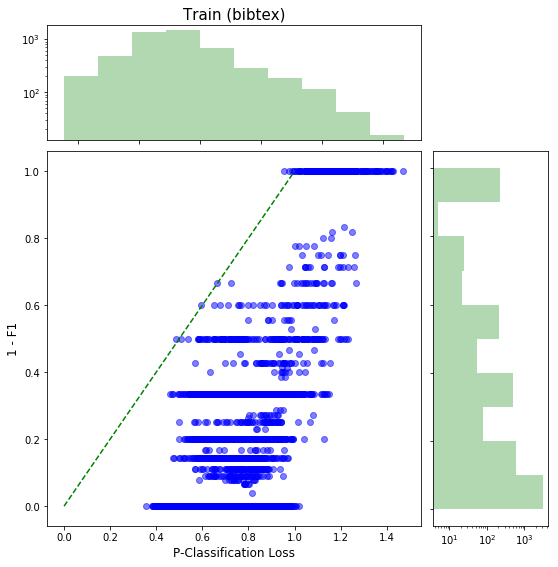

In [29]:
th_train = 0.9
title = 'Train (' + dataset_name + ')'
loss_train = loss_pclassification(W=clf.best_estimator_.W, X=X_train, Y=Y_train, p=clf.best_params_['p'])
plot_loss(loss_train, 1-calcF1(Y_train, clf.decision_function(X_train) >= th_train), xlabel, ylabel, title)

away from diagonal portion: 1.0


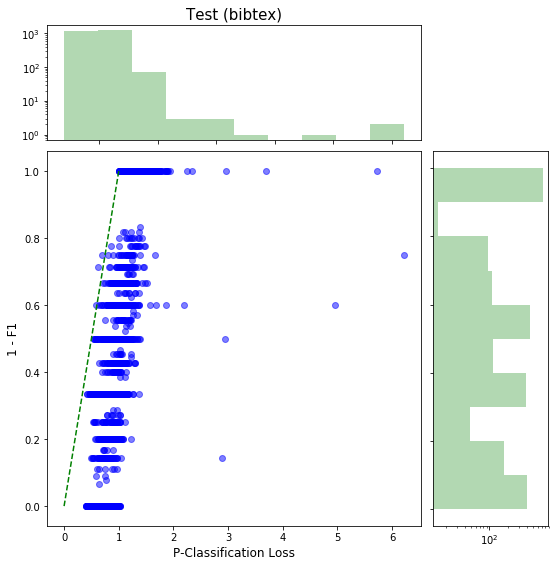

In [30]:
th_test = 0.8
title = 'Test (' + dataset_name + ')'
loss_test = loss_pclassification(W=clf.best_estimator_.W, X=X_test, Y=Y_test, p=clf.best_params_['p'])
plot_loss(loss_test, 1-calcF1(Y_test, clf.decision_function(X_test) >= th_test), xlabel, ylabel, title)

In [ ]:
indices = pd.MultiIndex.from_product([['yeast', 'bibtex'], ['Logistic Regression', 'P-Classification'], 
                                      ['Train', 'Test']], names=['Dataset', 'Method', 'Split'])

In [ ]:
result = pd.DataFrame(index=indices, columns=['F1', 'Precision@K', 'P-Classification Loss'])

In [ ]:
#result = pkl.load(open('tmp.tmp', 'rb'))

In [ ]:
result.loc[(dataset_name, 'P-Classification', 'Train'), 'F1'] = avgF1(Y_train, clf.decision_function(X_train))
result.loc[(dataset_name, 'P-Classification', 'Test'), 'F1'] = avgF1(Y_test, clf.decision_function(X_test))

result.loc[(dataset_name, 'P-Classification', 'Train'), 'Precision@K'] = avgPrecisionK(Y_train, 
                                                                                   clf.decision_function(X_train))
result.loc[(dataset_name, 'P-Classification', 'Test'), 'Precision@K'] = avgPrecisionK(Y_test, 
                                                                                  clf.decision_function(X_test))

result.loc[(dataset_name, 'P-Classification', 'Train'), 'P-Classification Loss'] = \
    np.mean(loss_pclassification(W=clf.best_estimator_.W, X=X_train, Y=Y_train, p=clf.best_params_['p']))
result.loc[(dataset_name, 'P-Classification', 'Test'), 'P-Classification Loss'] = \
    np.mean(loss_pclassification(W=clf.best_estimator_.W, X=X_test, Y=Y_test, p=clf.best_params_['p']))

In [ ]:
from BinaryRelevance import BinaryRelevance
br_clf = pkl.load(open(os.path.join(data_dir, 'br-' + dataset_name + '-f1.pkl'), 'rb'))

In [ ]:
br_clf.best_estimator_.estimator.coef_.shape

In [ ]:
losses = loss_pclassification(W=br_clf.best_estimator_.estimator.coef_, X=X_train, Y=Y_train, p=2)
#np.mean(losses[losses < 1000])
#np.sum(losses > 1000)

In [ ]:
losses.min()

In [ ]:
print('%g' % losses.max())

In [ ]:
45 / losses.shape[0]
losses.shape

In [ ]:
p = 2  # dataset specific from cross validation of P-Classification

In [ ]:
result.loc[(dataset_name, 'Logistic Regression', 'Train'), 'F1'] = \
    f1_score_nowarn(Y_train, br_clf.decision_function(X_train) >= 0, average='samples')
result.loc[(dataset_name, 'Logistic Regression', 'Test'), 'F1'] = \
    f1_score_nowarn(Y_test, br_clf.decision_function(X_test) >= 0, average='samples')

result.loc[(dataset_name, 'Logistic Regression', 'Train'), 'Precision@K'] = \
    avgPrecisionK(Y_train, br_clf.decision_function(X_train))
result.loc[(dataset_name, 'Logistic Regression', 'Test'), 'Precision@K'] = \
    avgPrecisionK(Y_test, br_clf.decision_function(X_test))

result.loc[(dataset_name, 'Logistic Regression', 'Train'), 'P-Classification Loss'] = \
    np.mean(loss_pclassification(W=br_clf.best_estimator_.estimator.coef_, X=X_train, Y=Y_train, p=p))
result.loc[(dataset_name, 'Logistic Regression', 'Test'), 'P-Classification Loss'] = \
    np.mean(loss_pclassification(W=br_clf.best_estimator_.estimator.coef_, X=X_test, Y=Y_test, p=p))

In [ ]:
pkl.dump(result, open('tmp.tmp', 'wb'))

In [ ]:
rstr = result.to_latex(float_format=lambda x: '$%.4f$' % x, na_rep='-', multirow=True, escape=False)
print('\\begin{table}[!h]')
print('\centering')
#print('\\caption{Performance on test set}')
print('\\label{tab:perf}')    
print(rstr)
print('\\end{table}')